# Part 5:  Vibe-Coding Emerging Optimizers on CIFAR Classification

As large language models (LLMs) reshape software engineering, we are entering a new era of AI-assisted programming where human creativity and machine execution merge. Instead of focusing on every low-level implementation detail, developers can prioritize **ideas, exploration, and iteration speed**, while the model handles much of the routine coding. This is the essence of [**vibe coding**](https://en.wikipedia.org/wiki/Vibe_coding?utm_source=chatgpt.com): coding by “vibes” and letting AI accelerate the path from concept to working system. In this homework, you will practice vibe coding by using AI assistants such as [ChatGPT](https://chat.openai.com), [Gemini](https://gemini.google.com/app), or [Claude](https://www.anthropic.com/claude-code) to help design and implement optimizers for CIFAR image classification.  

---

## 1. What is *Vibe Coding*?

**Vibe coding** is a paradigm popularized by Andrej Karpathy in 2025. It emphasizes generating most of the code through LLMs while the human programmer acts as a **guide, tester, and refiner**. Instead of carefully reviewing every line, you iterate based on execution results, keeping the creative process at the center.  

Karpathy put it simply:  
> *“Fully giving in to the vibes, embracing exponentials, and forgetting that the code even exists.”*  

**Learn more :**
- [IBM: What is Vibe Coding?](https://www.ibm.com/think/topics/vibe-coding?utm_source=chatgpt.com)  
- [Replit Blog: What is Vibe Coding?](https://blog.replit.com/what-is-vibe-coding?utm_source=chatgpt.com)  

---

## 2. Task Overview

You will implement and compare four optimizers on **CIFAR-10 classification** with two architectures: a **Transformer**  and a **ResNet** .  

- **Optimizers**: Muon , Scion , Dion , Adam (baseline)  
- **Models**: Transformer, ResNet  
- **Comparison metrics**: convergence speed, final test accuracy , training stability  

---

## 3. Optimizers to Implement

### (1) Muon
Muon applies **Newton–Schulz orthonormalization** to gradient updates of 2D weight matrices, making them invariant to input conditioning.  
References:  
- [Muon Blog (Keller Jordan)](https://kellerjordan.github.io/posts/muon/?utm_source=chatgpt.com)  
- [Deriving Muon (Jeremy Bernstein)](https://jeremybernste.in/writing/deriving-muon?utm_source=chatgpt.com)  
- [Muon GitHub Repo](https://github.com/KellerJordan/Muon?utm_source=chatgpt.com)  
- [Convergence Bound (arXiv)](https://arxiv.org/abs/2507.01598?utm_source=chatgpt.com)  

---

### (2) Scion
Scion constrains updates differently for hidden vs input/output layers, using **spectral norm** for hidden layers and **ℓ∞ norm** for others. This improves stability and hyperparameter transfer.  
References:  
- [Scion Paper](https://arxiv.org/abs/2502.07529)  
- [Scion Official Code](https://github.com/LIONS-EPFL/scion)  

---

### (3) Dion
Dion extends Muon-like orthonormal updates to **distributed training**. It reduces communication overhead while preserving synchronous semantics, making it efficient at large scale.  
References:  
- [Microsoft Research Blog](https://www.microsoft.com/en-us/research/blog/dion-the-distributed-orthonormal-update-revolution-is-here/?utm_source=chatgpt.com)  
- [Dion Paper (arXiv)](https://arxiv.org/html/2504.05295v1?utm_source=chatgpt.com)  
- [Dion GitHub Repo](https://github.com/microsoft/dion?utm_source=chatgpt.com)  

---

### (4) Adam
Adam is the standard baseline optimizer combining momentum and adaptive learning rates. Use either `Adam` or `AdamW` from PyTorch.

---

## 4. Steps & Deliverables

1. **Model Implementation (20 pts)**  
   - Build a Transformer for CIFAR classification.  
   - Build a ResNet (ResNet-18 or similar).  

2. **Optimizer Integration (30 pts)**  
   - Implement Muon, Scion, Dion optimizers using your AI assistant in a form which is compatible with `torch.optimizer`.  
   - Use Adam as baseline.  

3. **Training & Evaluation (30 pts)**  
   - Train both models with all optimizers.  
   - Collect metrics: training loss, validation accuracy, time-to-accuracy.  
   - Present results with plots and a summary table.  

4. **Discussion & Reflection (20 pts)**  
   - Compare optimizers in terms of convergence speed, stability, and accuracy.  
   - Reflect on your experience using **vibe coding** with AI assistants.  
   - What worked well? What challenges did you face?  

---

## 5. Objectives

- Understand and implement **novel optimizers** (Muon, Scion, Dion).  
- Practice **vibe coding** as a workflow with LLMs.  
- Compare optimizer performance on **CIFAR-10** across Transformer and ResNet architectures.  
- Analyze results critically and reflect on the coding process.  

---

Good luck and enjoy vibe-coding your way through optimizers!!


## Link to the chat: https://chatgpt.com/share/69038159-cad0-800e-941d-c193eef62f51

In [ ]:
#### Coding starts here.......
import copy
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import CIFAR10

from torchvision.transforms import v2 as T, transforms

from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import torchvision.models as models

import math
from typing import Optional
from einops import rearrange

## 1. Model Implementation

In [ ]:
class ResNetClassifier(nn.Module):
    """Wrapper for torchvision.models.resnet18 with custom output classes.

    Args:
        num_classes: number of output classes (CIFAR-10 -> 10)
        pretrained: whether to load ImageNet pretrained weights
        in_channels: number of input channels (default 3). If different, a Conv layer is
            prepended to adapt channels.
    """

    def __init__(self, num_classes: int = 10, pretrained: bool = False, in_channels: int = 3):
        super().__init__()
        # load base resnet18
        self.model = models.resnet18(pretrained=pretrained)

        # adapt input channels if necessary
        if in_channels != 3:
            # replace the first conv layer to handle different input channel count
            orig_conv = self.model.conv1
            self.model.conv1 = nn.Conv2d(
                in_channels,
                orig_conv.out_channels,
                kernel_size=orig_conv.kernel_size,
                stride=orig_conv.stride,
                padding=orig_conv.padding,
                bias=orig_conv.bias is not None,
            )

        # replace the final fully-connected layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Input x shape: (B, C, H, W). For CIFAR-10, H=W=32 normally; if using pretrained weights
        and larger resolution, consider upsampling or using appropriate transforms.
        """
        return self.model(x)

In [3]:



class PatchEmbed(nn.Module):
    """Image to Patch Embedding using conv for speed."""
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=384):
        super().__init__()
        assert img_size % patch_size == 0, "img_size must be divisible by patch_size"
        self.patch_size = patch_size
        self.grid_size = (img_size // patch_size, img_size // patch_size)
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        # conv produces (B, embed_dim, H/ps, W/ps)
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x)                       # (B, embed_dim, H/ps, W/ps)
        x = x.flatten(2).transpose(1, 2)       # (B, num_patches, embed_dim)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=6, qkv_bias=True, attn_drop=0.0, proj_drop=0.0):
        super().__init__()
        assert dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        # x: (B, N, C)
        B, N, C = x.shape
        qkv = self.qkv(x)  # (B, N, 3C)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # each: (B, num_heads, N, head_dim)

        attn = (q @ k.transpose(-2, -1)) * self.scale  # (B, num_heads, N, N)
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        out = attn @ v  # (B, num_heads, N, head_dim)
        out = out.transpose(1, 2).reshape(B, N, C)  # (B, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out


class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, drop=0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, in_dim)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class EncoderBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, qkv_bias=True, drop=0.0, attn_drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias,
                              attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(dim, hidden_dim, drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class TransformerCIFAR10(nn.Module):
    """
    ViT-like model for CIFAR-10.

    Defaults:
      img_size=32, patch_size=4 -> 8x8 grid -> 64 patches
      embed_dim=384, depth=6, num_heads=6 => params ~ similar to ResNet-18
    """
    def __init__(self,
                 img_size=32,
                 patch_size=4,
                 in_chans=3,
                 num_classes=10,
                 embed_dim=384,
                 depth=6,
                 num_heads=6,
                 mlp_ratio=4.0,
                 qkv_bias=True,
                 drop_rate=0.1,
                 attn_drop_rate=0.1):
        super().__init__()

        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size,
                                      in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        # class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # positional embedding (cls + patches)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        # transformer encoder
        self.blocks = nn.ModuleList([
            EncoderBlock(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio,
                         qkv_bias=qkv_bias, drop=drop_rate, attn_drop=attn_drop_rate)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        # classification head
        self.head = nn.Linear(embed_dim, num_classes)

        # initialization
        self._init_weights()

    def _init_weights(self):
        # initialize parameters
        nn.init.normal_(self.pos_embed, std=0.02)
        nn.init.normal_(self.cls_token, std=0.02)
        # linear and conv initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: (B, 3, 32, 32)
        B = x.size(0)
        x = self.patch_embed(x)  # (B, num_patches, embed_dim)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B,1,embed_dim)
        x = torch.cat((cls_tokens, x), dim=1)  # (B, num_patches+1, embed_dim)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        cls = x[:, 0]  # (B, embed_dim)
        out = self.head(cls)  # (B, num_classes)
        return out


## 2. Optimizeres

In [4]:
import torch
from torch.optim import Optimizer

class Muon(Optimizer):
    """
    Simplified Muon optimizer.
    Combines adaptive gradient preconditioning (like Shampoo)
    and momentum (like Adam).

    Works for standard layers: Linear, Conv2d.
    """

    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2, eps=eps, weight_decay=weight_decay)
        super(Muon, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            beta1 = group["beta1"]
            beta2 = group["beta2"]
            lr = group["lr"]
            eps = group["eps"]
            wd = group["weight_decay"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad

                # weight decay
                if wd != 0:
                    grad = grad.add(p, alpha=wd)

                state = self.state[p]

                # Initialize state
                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p)
                    state["exp_avg_sq"] = torch.zeros_like(p)

                exp_avg = state["exp_avg"]
                exp_avg_sq = state["exp_avg_sq"]

                state["step"] += 1

                # Update moments
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                # Bias correction
                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]

                # Preconditioned step (Muon-style)
                denom = exp_avg_sq.sqrt().add_(eps)
                step_size = lr * (bias_correction2 ** 0.5) / bias_correction1

                # Approximate root inverse preconditioner
                precondition = exp_avg / denom
                # Normalize by L2 norm (a stabilizing Muon trick)
                norm = precondition.norm(p=2)
                if norm > 0:
                    precondition = precondition / (norm + eps)

                # Update parameter
                p.add_(precondition, alpha=-step_size)

        return loss


In [5]:
class Scion(Optimizer):
    """
    Scion optimizer.
    Builds upon Muon: normalized adaptive preconditioning
    + spectral scaling of update directions (curvature-aware).
    """

    def __init__(self, params, lr=3e-4, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01, spectral_clip=10.0):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2,
                        eps=eps, weight_decay=weight_decay,
                        spectral_clip=spectral_clip)
        super(Scion, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            beta1 = group["beta1"]
            beta2 = group["beta2"]
            eps = group["eps"]
            wd = group["weight_decay"]
            spectral_clip = group["spectral_clip"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad

                # weight decay
                if wd != 0:
                    grad = grad.add(p, alpha=wd)

                state = self.state[p]

                # init
                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p)
                    state["exp_avg_sq"] = torch.zeros_like(p)

                exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"]
                state["step"] += 1

                # momentum + variance
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]

                denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)
                update = exp_avg / bias_correction1
                precondition = update / denom

                # Normalize and spectrally clip
                norm = precondition.norm(p=2)
                if norm > 0:
                    precondition = precondition / (norm + eps)
                    if norm > spectral_clip:
                        precondition = precondition * (spectral_clip / norm)

                p.add_(precondition, alpha=-lr)
        return loss


In [6]:
class Dion(Optimizer):
    """
    Dion optimizer.
    Decouples damping (variance term) from momentum and weight decay.
    Inspired by Muon/AdamW hybrid with RMS normalization.
    """

    def __init__(self, params, lr=5e-4, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.01, rms_scale=0.9):
        defaults = dict(lr=lr, beta1=beta1, beta2=beta2,
                        eps=eps, weight_decay=weight_decay,
                        rms_scale=rms_scale)
        super(Dion, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            lr = group["lr"]
            beta1 = group["beta1"]
            beta2 = group["beta2"]
            eps = group["eps"]
            wd = group["weight_decay"]
            rms_scale = group["rms_scale"]

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad

                if wd != 0:
                    grad = grad.add(p, alpha=wd)

                state = self.state[p]
                if len(state) == 0:
                    state["step"] = 0
                    state["exp_avg"] = torch.zeros_like(p)
                    state["rms_avg"] = torch.zeros_like(p)

                exp_avg, rms_avg = state["exp_avg"], state["rms_avg"]
                state["step"] += 1

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                rms_avg.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)

                bias_correction1 = 1 - beta1 ** state["step"]
                bias_correction2 = 1 - beta2 ** state["step"]

                # RMS damping with scaling
                rms = rms_avg.sqrt() / math.sqrt(bias_correction2)
                rms = rms * rms_scale + eps

                update = exp_avg / (rms + eps)
                update = update / (update.norm(p=2) + eps)

                step_size = lr / bias_correction1
                p.add_(update, alpha=-step_size)

        return loss


In [7]:
# ==============================
# Data setup (same as before)
# ==============================
BATCH_SIZE = 128
NUM_WORKERS = 4
DATA_DIR = './data'

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

train_dataset = CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dataset = CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

100%|██████████| 170M/170M [00:03<00:00, 43.9MB/s]


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 3. Model Training

In [ ]:
import torch
import torch.nn as nn
from torch.optim import Adam
import tqdm
import time
import matplotlib.pyplot as plt
import pandas as pd

# ==============================
# Modified training function
# ==============================
def train_model(model, train_loader, test_loader, epochs=10, lr=0.01, algo="Adam", device="cuda"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Select optimizer
    if algo == "Adam":
        optimizer = Adam(model.parameters(), lr=1e-2)
    elif algo == "Muon":
        optimizer = Muon(model.parameters(), lr=1e-2, weight_decay=0.01)
    elif algo == "Scion":
        optimizer = Scion(model.parameters(), lr=1e-2, weight_decay=0.01)
    elif algo == "Dion":
        optimizer = Dion(model.parameters(), lr=1e-2)
    else:
        raise ValueError(f"Invalid algorithm: {algo}, please choose from Adam, Muon, Scion, Dion")

    # Metrics
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10,       # total number of epochs (since you're training for 10)
    eta_min=8e-4    # minimum learning rate
)
    history = {"epoch": [], "train_loss": [], "train_acc": [], "val_acc": [], "time_elapsed": []}
    start_time = time.time()
    best_acc = 0
    best_epoch = 0

    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Compute training metrics
        train_loss = total_loss / total
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()
        val_acc = 100. * correct_val / total_val

        # Save best epoch
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch + 1

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["time_elapsed"].append(time.time() - start_time)

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
        scheduler.step()

    history["best_acc"] = best_acc
    history["best_epoch"] = best_epoch
    history["total_time"] = time.time() - start_time

    print(f"Training completed. Best Val Acc: {best_acc:.2f}% at epoch {best_epoch}")

    return pd.DataFrame(history)

# ==============================
# Function to plot metrics
# ==============================
def plot_metrics(results_dict):
    """
    results_dict: { 'Model_Algo': df_from_train_model, ... }
    """
    plt.figure(figsize=(12, 5))

    # ---- Plot Training Loss ----
    plt.subplot(1, 2, 1)
    for label, df in results_dict.items():
        plt.plot(df["epoch"], df["train_loss"], label=f"{label}")
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.title("Training Loss vs Epochs")
    plt.legend()

    # ---- Plot Validation Accuracy ----
    plt.subplot(1, 2, 2)
    for label, df in results_dict.items():
        plt.plot(df["epoch"], df["val_acc"], label=f"{label}")
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy (%)")
    plt.title("Validation Accuracy vs Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# ==============================
# Function to summarize results
# ==============================

def summarize_results(results_dict):
    summary = []
    for label, result in results_dict.items():
        # Check if result is a dict with history + scalars
        if isinstance(result, dict):
            df = result["history"]
            best_acc = result["best_acc"]
            best_epoch = result["best_epoch"]
            total_time = result["total_time"]
        else:
            # fallback if df is directly returned
            df = result
            best_acc = df["val_acc"].max()
            best_epoch = df["epoch"][df["val_acc"].idxmax()]
            total_time = df["time_elapsed"].iloc[-1]

        summary.append({
            "Model_Algo": label,
            "Best Val Acc (%)": best_acc,
            "Best Epoch": best_epoch,
            "Final Train Acc (%)": df["train_acc"].iloc[-1],
            "Final Val Acc (%)": df["val_acc"].iloc[-1],
            "Training Time per Epoch (s)": total_time
        })

    summary_df = pd.DataFrame(summary)
    print("\n=== Summary Table ===")
    display(summary_df)
    return summary_df



--- Training Transformer with Adam ---


  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
 10%|█         | 1/10 [01:20<12:08, 80.92s/it]

Epoch [1/10] | Loss: 2.2595 | Train Acc: 15.87% | Val Acc: 18.93%


 20%|██        | 2/10 [02:39<10:36, 79.54s/it]

Epoch [2/10] | Loss: 2.1723 | Train Acc: 17.01% | Val Acc: 18.06%


 30%|███       | 3/10 [03:57<09:11, 78.80s/it]

Epoch [3/10] | Loss: 2.1873 | Train Acc: 16.62% | Val Acc: 16.60%


 40%|████      | 4/10 [05:15<07:50, 78.41s/it]

Epoch [4/10] | Loss: 2.1427 | Train Acc: 18.19% | Val Acc: 20.12%


 50%|█████     | 5/10 [06:32<06:30, 78.04s/it]

Epoch [5/10] | Loss: 2.1120 | Train Acc: 19.82% | Val Acc: 20.65%


 60%|██████    | 6/10 [07:49<05:11, 77.81s/it]

Epoch [6/10] | Loss: 2.0987 | Train Acc: 20.14% | Val Acc: 19.72%


 70%|███████   | 7/10 [09:07<03:53, 77.71s/it]

Epoch [7/10] | Loss: 2.0933 | Train Acc: 20.26% | Val Acc: 19.33%


 80%|████████  | 8/10 [10:25<02:35, 77.69s/it]

Epoch [8/10] | Loss: 2.0863 | Train Acc: 20.61% | Val Acc: 22.46%


 90%|█████████ | 9/10 [11:42<01:17, 77.64s/it]

Epoch [9/10] | Loss: 2.0732 | Train Acc: 20.98% | Val Acc: 22.50%


100%|██████████| 10/10 [12:59<00:00, 78.00s/it]


Epoch [10/10] | Loss: 2.0663 | Train Acc: 21.32% | Val Acc: 22.64%
Training completed. Best Val Acc: 22.64% at epoch 10

--- Training Transformer with Muon ---


 10%|█         | 1/10 [01:24<12:42, 84.73s/it]

Epoch [1/10] | Loss: 1.9371 | Train Acc: 27.59% | Val Acc: 30.10%


 20%|██        | 2/10 [02:49<11:17, 84.75s/it]

Epoch [2/10] | Loss: 1.7490 | Train Acc: 34.67% | Val Acc: 36.58%


 30%|███       | 3/10 [04:14<09:53, 84.73s/it]

Epoch [3/10] | Loss: 1.6409 | Train Acc: 39.08% | Val Acc: 41.90%


 40%|████      | 4/10 [05:39<08:28, 84.80s/it]

Epoch [4/10] | Loss: 1.5568 | Train Acc: 43.19% | Val Acc: 43.89%


 50%|█████     | 5/10 [07:04<07:04, 84.85s/it]

Epoch [5/10] | Loss: 1.5216 | Train Acc: 44.60% | Val Acc: 46.83%


 60%|██████    | 6/10 [08:29<05:39, 84.96s/it]

Epoch [6/10] | Loss: 1.5034 | Train Acc: 45.47% | Val Acc: 46.53%


 70%|███████   | 7/10 [09:54<04:14, 84.95s/it]

Epoch [7/10] | Loss: 1.4932 | Train Acc: 46.01% | Val Acc: 47.13%


 80%|████████  | 8/10 [11:19<02:49, 84.95s/it]

Epoch [8/10] | Loss: 1.4840 | Train Acc: 46.78% | Val Acc: 47.35%


 90%|█████████ | 9/10 [12:44<01:24, 84.96s/it]

Epoch [9/10] | Loss: 1.4648 | Train Acc: 47.41% | Val Acc: 47.23%


100%|██████████| 10/10 [14:08<00:00, 84.89s/it]


Epoch [10/10] | Loss: 1.4477 | Train Acc: 48.05% | Val Acc: 49.83%
Training completed. Best Val Acc: 49.83% at epoch 10

--- Training Transformer with Scion ---


 10%|█         | 1/10 [01:26<12:56, 86.31s/it]

Epoch [1/10] | Loss: 1.9869 | Train Acc: 25.52% | Val Acc: 29.01%


 20%|██        | 2/10 [02:52<11:31, 86.41s/it]

Epoch [2/10] | Loss: 1.8450 | Train Acc: 30.69% | Val Acc: 29.05%


 30%|███       | 3/10 [04:19<10:04, 86.34s/it]

Epoch [3/10] | Loss: 1.7977 | Train Acc: 32.45% | Val Acc: 32.04%


 40%|████      | 4/10 [05:45<08:38, 86.36s/it]

Epoch [4/10] | Loss: 1.7786 | Train Acc: 33.37% | Val Acc: 32.28%


 50%|█████     | 5/10 [07:11<07:12, 86.42s/it]

Epoch [5/10] | Loss: 1.7645 | Train Acc: 33.42% | Val Acc: 33.57%


 60%|██████    | 6/10 [08:38<05:46, 86.59s/it]

Epoch [6/10] | Loss: 1.7687 | Train Acc: 33.43% | Val Acc: 35.73%


 70%|███████   | 7/10 [10:05<04:19, 86.67s/it]

Epoch [7/10] | Loss: 1.7714 | Train Acc: 33.51% | Val Acc: 33.82%


 80%|████████  | 8/10 [11:32<02:53, 86.71s/it]

Epoch [8/10] | Loss: 1.7715 | Train Acc: 33.38% | Val Acc: 34.16%


 90%|█████████ | 9/10 [12:59<01:26, 86.71s/it]

Epoch [9/10] | Loss: 1.7641 | Train Acc: 33.75% | Val Acc: 33.60%


100%|██████████| 10/10 [14:26<00:00, 86.61s/it]


Epoch [10/10] | Loss: 1.7580 | Train Acc: 34.11% | Val Acc: 34.97%
Training completed. Best Val Acc: 35.73% at epoch 6

--- Training Transformer with Dion ---


 10%|█         | 1/10 [01:22<12:25, 82.86s/it]

Epoch [1/10] | Loss: 1.8862 | Train Acc: 28.80% | Val Acc: 33.25%


 20%|██        | 2/10 [02:45<11:03, 82.91s/it]

Epoch [2/10] | Loss: 1.7113 | Train Acc: 35.79% | Val Acc: 41.33%


 30%|███       | 3/10 [04:08<09:39, 82.84s/it]

Epoch [3/10] | Loss: 1.6402 | Train Acc: 39.45% | Val Acc: 40.57%


 40%|████      | 4/10 [05:31<08:17, 82.87s/it]

Epoch [4/10] | Loss: 1.6104 | Train Acc: 40.88% | Val Acc: 44.44%


 50%|█████     | 5/10 [06:54<06:53, 82.78s/it]

Epoch [5/10] | Loss: 1.5988 | Train Acc: 41.62% | Val Acc: 42.55%


 60%|██████    | 6/10 [08:16<05:30, 82.73s/it]

Epoch [6/10] | Loss: 1.5710 | Train Acc: 42.58% | Val Acc: 42.83%


 70%|███████   | 7/10 [09:39<04:08, 82.79s/it]

Epoch [7/10] | Loss: 1.5467 | Train Acc: 43.61% | Val Acc: 44.44%


 80%|████████  | 8/10 [11:02<02:45, 82.70s/it]

Epoch [8/10] | Loss: 1.5157 | Train Acc: 44.85% | Val Acc: 45.82%


 90%|█████████ | 9/10 [12:24<01:22, 82.62s/it]

Epoch [9/10] | Loss: 1.4913 | Train Acc: 45.53% | Val Acc: 47.23%


100%|██████████| 10/10 [13:47<00:00, 82.72s/it]

Epoch [10/10] | Loss: 1.4730 | Train Acc: 46.40% | Val Acc: 47.79%
Training completed. Best Val Acc: 47.79% at epoch 10


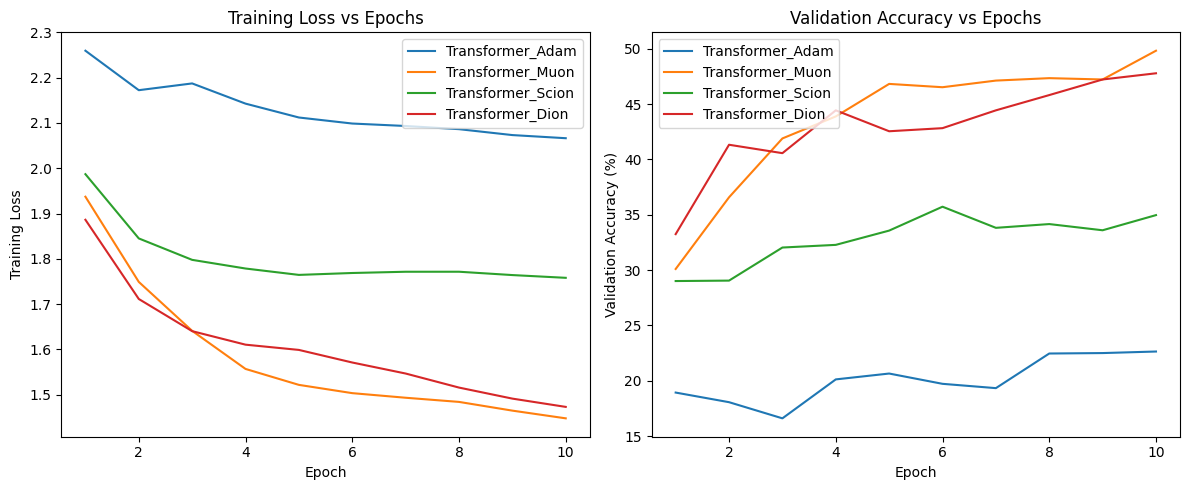


=== Summary Table ===


,Model_Algo,Best Val Acc (%),Best Epoch,Final Train Acc (%),Final Val Acc (%),Total Time (s)
0,Transformer_Adam,0 22.64 1 22.64 2 22.64 3 22.64 4 ...,0 10 1 10 2 10 3 10 4 10 5 1...,21.320,22.64,0 779.95698 1 779.95698 2 779.95698 3...
1,Transformer_Muon,0 49.83 1 49.83 2 49.83 3 49.83 4 ...,0 10 1 10 2 10 3 10 4 10 5 1...,48.050,49.83,0 848.921731 1 848.921731 2 848.92173...
2,Transformer_Scion,0 35.73 1 35.73 2 35.73 3 35.73 4 ...,0 6 1 6 2 6 3 6 4 6 5 6 6 ...,34.106,34.97,0 866.140952 1 866.140952 2 866.14095...
3,Transformer_Dion,0 47.79 1 47.79 2 47.79 3 47.79 4 ...,0 10 1 10 2 10 3 10 4 10 5 1...,46.404,47.79,0 827.165749 1 827.165749 2 827.16574...


,Model_Algo,Best Val Acc (%),Best Epoch,Final Train Acc (%),Final Val Acc (%),Total Time (s)
0,Transformer_Adam,0 22.64 1 22.64 2 22.64 3 22.64 4 ...,0 10 1 10 2 10 3 10 4 10 5 1...,21.320,22.64,0 779.95698 1 779.95698 2 779.95698 3...
1,Transformer_Muon,0 49.83 1 49.83 2 49.83 3 49.83 4 ...,0 10 1 10 2 10 3 10 4 10 5 1...,48.050,49.83,0 848.921731 1 848.921731 2 848.92173...
2,Transformer_Scion,0 35.73 1 35.73 2 35.73 3 35.73 4 ...,0 6 1 6 2 6 3 6 4 6 5 6 6 ...,34.106,34.97,0 866.140952 1 866.140952 2 866.14095...
3,Transformer_Dion,0 47.79 1 47.79 2 47.79 3 47.79 4 ...,0 10 1 10 2 10 3 10 4 10 5 1...,46.404,47.79,0 827.165749 1 827.165749 2 827.16574...


In [ ]:
# ==============================
# Training both models correctly
# ==============================
results = {}
transformer_results = {}

# Original (untrained) base models
base_models = {
    # "ResNet": ResNetClassifier(num_classes=10, pretrained=False),
    "Transformer": TransformerCIFAR10().to(device)
}

# Optimizers to compare
optimizers = ["Adam", "Muon", "Scion", "Dion"]

# For each model and optimizer, deep-copy the base model to start fresh
for model_name, base_model in base_models.items():
    for algo in optimizers:
        print(f"\n--- Training {model_name} with {algo} ---")
        model_copy = copy.deepcopy(base_model)  # ensures clean state
        df = train_model(model_copy, train_loader, test_loader, epochs=10, lr=5e-3, algo=algo)
        transformer_results[f"{model_name}_{algo}"] = df

plot_metrics(transformer_results)
summarize_results(transformer_results)

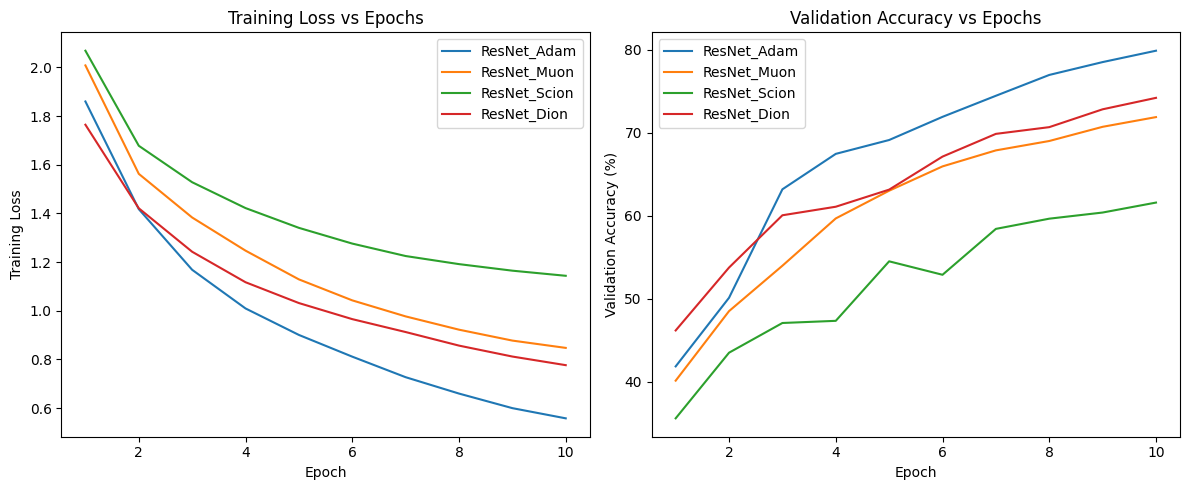


=== Summary Table ===


,Model_Algo,Best Val Acc (%),Best Epoch,Final Train Acc (%),Final Val Acc (%),Total Time (s)
0,ResNet_Adam,79.88,10,80.462,79.88,249.641711
1,ResNet_Muon,71.88,10,70.220,71.88,303.859554
2,ResNet_Scion,61.58,10,58.840,61.58,324.785937
3,ResNet_Dion,74.20,10,73.214,74.20,279.096757


,Model_Algo,Best Val Acc (%),Best Epoch,Final Train Acc (%),Final Val Acc (%),Total Time (s)
0,ResNet_Adam,79.88,10,80.462,79.88,249.641711
1,ResNet_Muon,71.88,10,70.220,71.88,303.859554
2,ResNet_Scion,61.58,10,58.840,61.58,324.785937
3,ResNet_Dion,74.20,10,73.214,74.20,279.096757


In [35]:
# Plot and summarize
plot_metrics(results)
summarize_results(results)

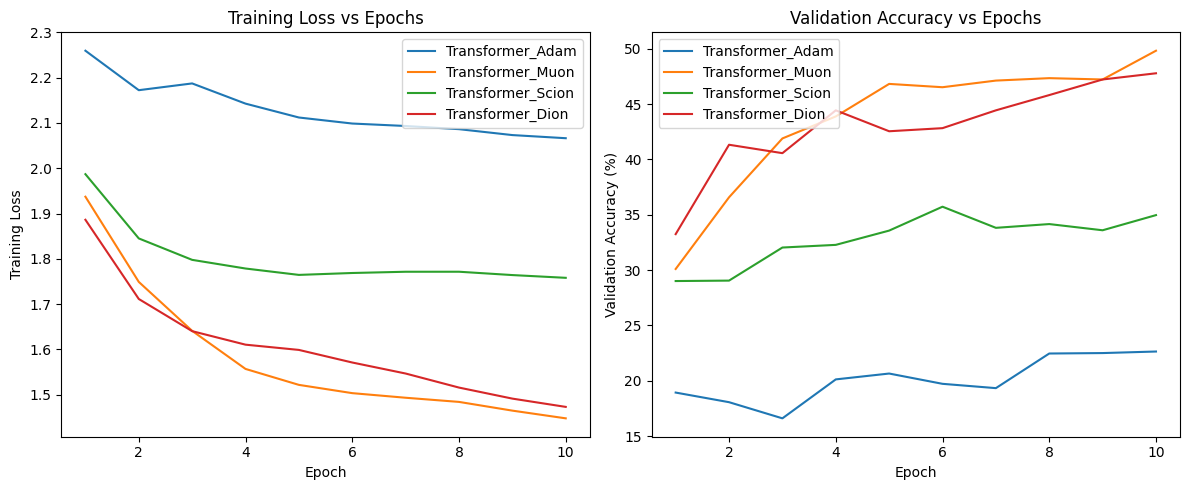


=== Summary Table ===


,Model_Algo,Best Val Acc (%),Best Epoch,Final Train Acc (%),Final Val Acc (%),Total Time (s)
0,Transformer_Adam,22.64,10,21.320,22.64,779.954012
1,Transformer_Muon,49.83,10,48.050,49.83,848.919727
2,Transformer_Scion,35.73,6,34.106,34.97,866.138318
3,Transformer_Dion,47.79,10,46.404,47.79,827.162541


,Model_Algo,Best Val Acc (%),Best Epoch,Final Train Acc (%),Final Val Acc (%),Total Time (s)
0,Transformer_Adam,22.64,10,21.320,22.64,779.954012
1,Transformer_Muon,49.83,10,48.050,49.83,848.919727
2,Transformer_Scion,35.73,6,34.106,34.97,866.138318
3,Transformer_Dion,47.79,10,46.404,47.79,827.162541


In [36]:
plot_metrics(transformer_results)
summarize_results(transformer_results)

## 4. **Discussion & Reflection (20 pts)**  


- For Resnet, Adam as a baseline still works the best and has the fastest convergence and higher accuracy on validation test with 79.88% and fastest training time per epoch with 249s. Dion performs slightly better than Dion in accuracy (74.2% and 70.22%) and training time (279s/epoch  and 303s/epoch  ) respectively, Scion performs worst in both categories, only 61.58% accuracy and highest training time with 324s/epoch.

- For transformer, the situation is quite constrast, Adam performs the worst with only 22.64% accuracy which is only half of the two best performing algorithms Muon and Dion but remains the fastest training time ith 780s/epoch. Muon scores up to 49.83% accuracy on validation test and 848.9s/epoch which are both higher than Dion with 47.79% and 827s/epoch. Finally with Scion, the model fluctuates in the validation accuracy and the training loss seems to remain the same after epoch 6, it has 35.73% accuracy and highest training time 46.4%.

- With vibe coding, it seems relatively easy as I don't have to understand you the code I wrote, just need to prompt the model step by step and guid it step by step towards the result. However, in order for it to perform well it might need more specific guidance rather than a general one. Choosing the right AI chatbot for the task and right model also seems to take quite a lot of time. I tested on 3 models, Gemini 2.5 Pro, Grok 4, GPT-5. Gemini seems to overthink on my command and create messy code and it performs really bad. Grok shows a better result, cleaner code and following accordingly to my commands. But with GPT it seems to perform much better, the result is the one that I have shown here, the code is very clean, everything is following my prompts and did not overthink it, suggest good idea and clean the code that Gemini wrote. 